In [57]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import os
import glob
import pandas as pd
import IPython.display as ipd
import plotly.express as px
import scipy.io.wavfile
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [58]:
#这个data只能在这个google folder里用
from google.colab import drive
drive.mount('/content/drive')

RAV = '/content/drive/MyDrive/Vision_Project/audio_speech_actors_01-24/'
dir_list = os.listdir(RAV)

emotion = []
gender = []
path = []
feature = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender'], axis=1)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

path = np.array(RAV_df.path)[1]
data, sample_rate = librosa.load(path)

In [60]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [61]:
import pickle
X, Y = [], []
for path, emotion in zip(RAV_df.path, RAV_df.emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [62]:
len(X), len(Y), RAV_df.path.shape

(4320, 4320, (1440,))

In [63]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

In [64]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [65]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
# Save the encoder
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [66]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 7), (1080, 162), (1080, 7))

In [67]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [68]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 7), (1080, 162, 1), (1080, 7))

In [69]:
model = Sequential()
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 162, 512)          3072      
                                                                 
 batch_normalization_18 (Ba  (None, 162, 512)          2048      
 tchNormalization)                                               
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 81, 512)           0         
 ng1D)                                                           
                                                                 
 conv1d_16 (Conv1D)          (None, 81, 512)           1311232   
                                                                 
 batch_normalization_19 (Ba  (None, 81, 512)           2048      
 tchNormalization)                                               
                                                      

### 8. Training :

In [70]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
102/102 [==============================] - 81s 26ms/step - loss: 2.0230 - accuracy: 0.2772 - val_loss: 2.0566 - val_accuracy: 0.2593 - lr: 0.0010
Epoch 2/100
102/102 [==============================] - 2s 23ms/step - loss: 1.6958 - accuracy: 0.3611 - val_loss: 2.5851 - val_accuracy: 0.2352 - lr: 0.0010
Epoch 3/100
102/102 [==============================] - 2s 19ms/step - loss: 1.6549 - accuracy: 0.3836 - val_loss: 2.1898 - val_accuracy: 0.2741 - lr: 0.0010
Epoch 4/100
102/102 [==============================] - 2s 19ms/step - loss: 1.5790 - accuracy: 0.4003 - val_loss: 2.2552 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 5/100
102/102 [==============================] - 2s 19ms/step - loss: 1.4969 - accuracy: 0.4349 - val_loss: 2.1766 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 6/100
102/102 [==============================] - 2s 20ms/step - loss: 1.4435 - accuracy: 0.4565 - val_loss: 2.2485 - val_accuracy: 0.1722 - lr: 0.0010
Epoch 7/100
102/102 [==============================] - 2s

### 9. Evaluation :

34/34 [==============================] - 0s 11ms/step - loss: 0.9653 - accuracy: 0.7769
Accuracy of our model on test data :  77.68518328666687 %


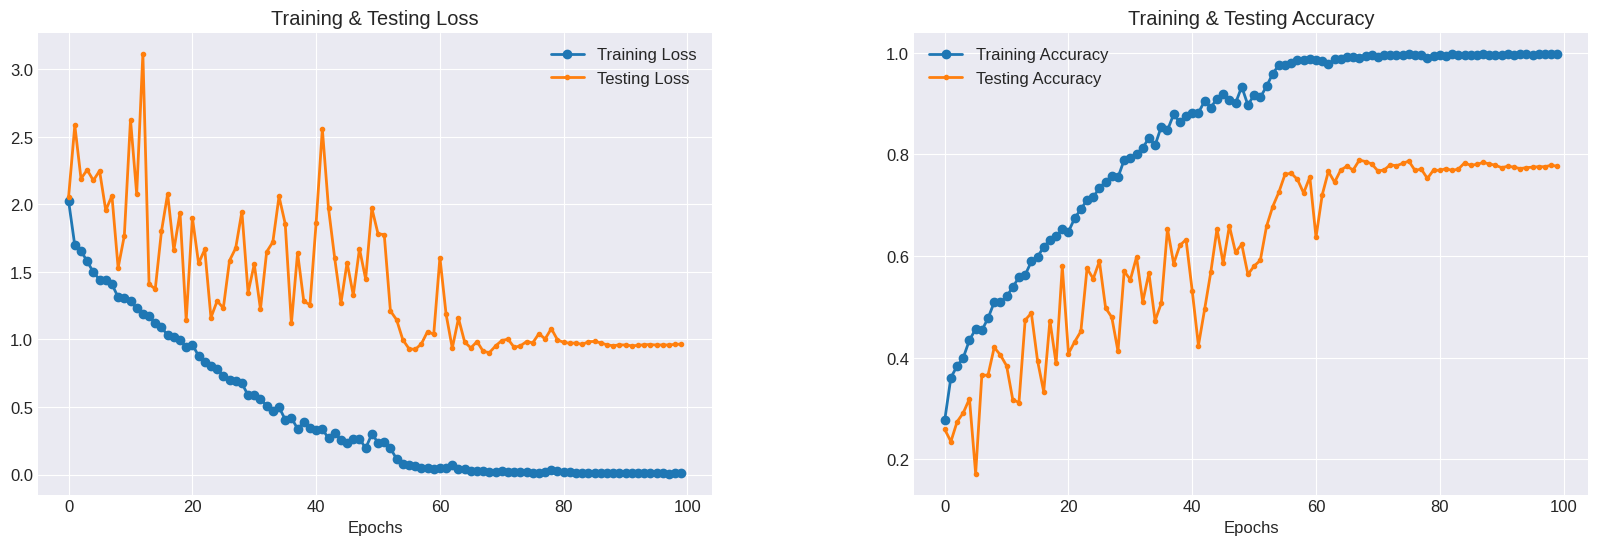

In [72]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 12})
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss',marker='o', linewidth=2)
ax[0].plot(epochs , test_loss , label = 'Testing Loss',marker='.', linewidth=2)
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy',marker='o', linewidth=2)
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy',marker='.', linewidth=2)
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.subplots_adjust(wspace=0.3)
plt.show()

In [73]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 0s 7ms/step


In [74]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

display(df.head())

,Predicted Labels,Actual Labels
0,fear,fear
1,sad,sad
2,neutral,neutral
3,happy,happy
4,angry,angry


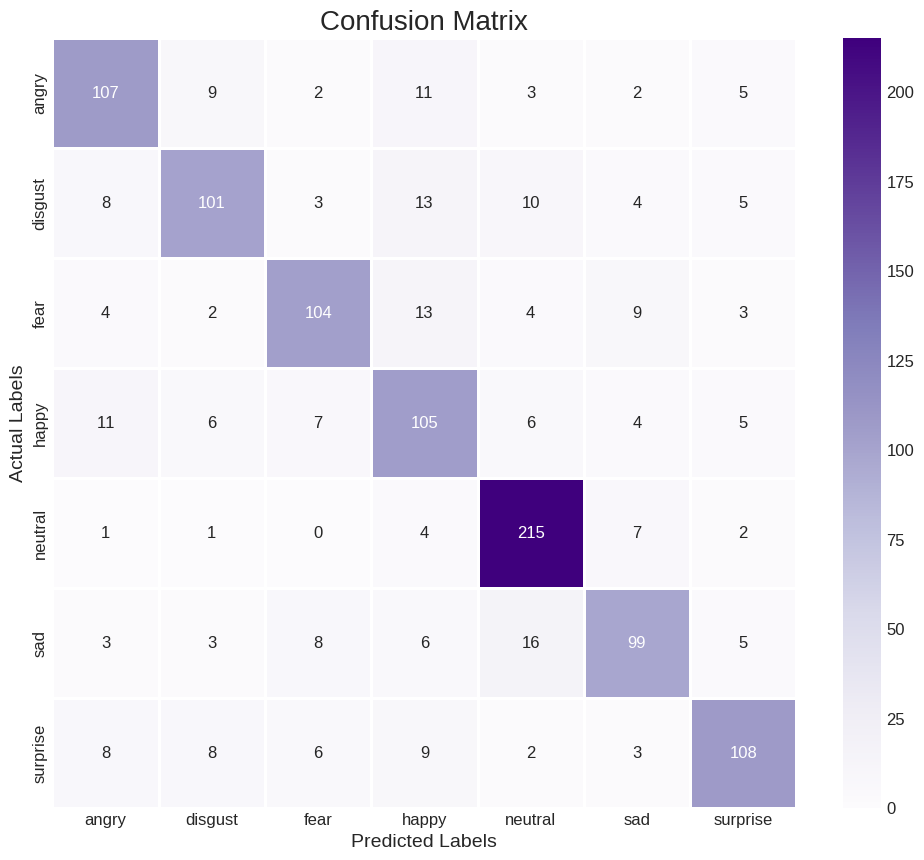

In [75]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.75      0.77      0.76       139
     disgust       0.78      0.70      0.74       144
        fear       0.80      0.75      0.77       139
       happy       0.65      0.73      0.69       144
     neutral       0.84      0.93      0.88       230
         sad       0.77      0.71      0.74       140
    surprise       0.81      0.75      0.78       144

    accuracy                           0.78      1080
   macro avg       0.77      0.76      0.77      1080
weighted avg       0.78      0.78      0.78      1080



In [77]:
from tensorflow.keras.models import save_model

model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
